In [21]:
# imports
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
from skimage.io import imread,imsave
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import skimage as sk
from skimage.morphology import *
from helpers import *
from preprocessing import *
from extract_features import *
%matplotlib inline

[6, 26, 12, 6, 9, 8, 6, 6, 6, 9, 7, 7, 6, 6, 7, 7, 19, 28, 10, 17, 7, 8, 9, 8, 7, 55, 62, 12, 9, 8, 8, 9, 9, 7, 21, 43, 10, 12, 13, 28, 9, 83, 7, 23, 9, 7, 6, 12, 7, 15]


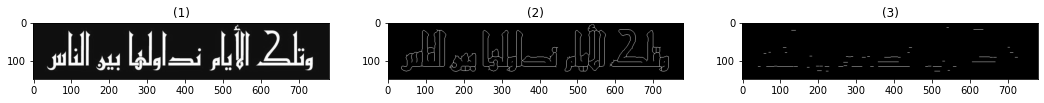

[20, 22, 6, 15, 15, 14, 14, 14, 15, 15, 14, 14, 15, 14, 14, 14, 15, 16, 6, 18, 18, 89, 34, 15, 43, 9, 17, 34, 16, 16, 33, 19, 72, 9, 9, 12, 16, 52, 17, 16, 18, 12]


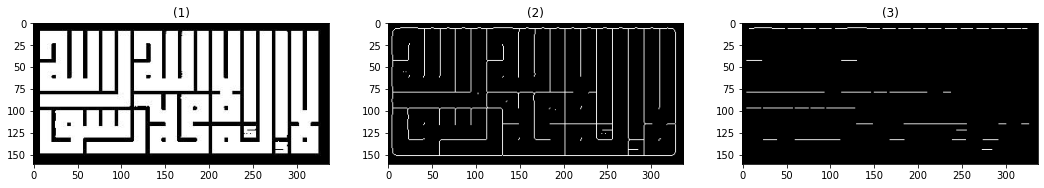

[6, 6, 6, 6, 7, 7, 6, 7, 6, 6, 7, 8, 11, 18, 10, 7, 7, 9, 7, 10, 8, 7, 6, 11, 6, 10, 6, 6, 8, 8, 7, 6, 6, 9, 7, 14, 6, 6, 6, 6, 10, 9, 7, 6, 7, 12, 7, 6, 7, 8, 6, 17, 7, 7, 8, 8, 11, 10, 7, 6, 6, 9, 7, 9, 7, 7, 6, 6, 7, 8, 6, 9, 6, 14, 9, 6, 6, 7, 7, 7, 7, 6, 6, 6, 13, 7, 8, 16]


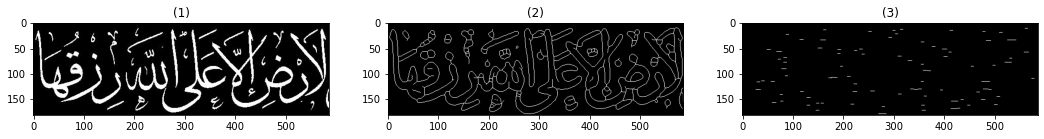

In [23]:
# read image
kufi_img = imread("./ACDB/ACdata_base/7/1128.jpg", as_gray=True)
skufi_img = imread("./ACDB/ACdata_base/9/1550.jpg", as_gray=True)
other_img = imread("./ACDB/ACdata_base/5/781.jpg", as_gray=True)

img = get_skeleton(kufi_img)
img2 = get_skeleton(skufi_img) 
img3 = get_skeleton(other_img) 
show_images([kufi_img,img,get_TTH(img)[1]])
show_images([skufi_img,img2,get_TTH(img2)[1]])
show_images([other_img,img3,get_TTH(img3)[1]])